# **DPP - Progetto**

"In this paper, we model a social network as a simple graph G = (V, E, L, *L*), where V is a set of vertices, E ⊆ V × V is a set of edges, L is a set of labels, and a labeling function *L* : V → L assigns each vertex a label. [...] To keep our discussion simple, we assume that edges do not carry labels. [...]     
The items in the label set L form a hierarchy. For example, if occupations are used as labels of vertices in a social network, L contains not only the specific occupations such as dentist, general physician, optometrist, high school teacher, and primary school teacher, but also general categories like medical doctor, teacher, and professional. We assume that there exists a meta symbol ∗ ∈ L which is the most general category generalizing all labels. For two labels l1, l2 ∈ L, if l1 is more general than l2, we write l1 ≺ l2. For example, medical doctor ≺ optometrist. Moreover, l1 ≺= l2 if and only if l1 ≺ l2 or l1 = l2. ≺= is a partial order on L."  

In [1]:
# ORIGINAL GRAPH TO PROTECT
import networkx as nx

# synthetic undirected graph generation
n = 100
m = 5
G = nx.barabasi_albert_graph(n=n, m=m, seed=42)
print(f"Number of nodes : {len(G.nodes())}")
print(f"Number of edges : {len(G.edges())}")

# importazione di un grafo reale (social network)

Number of nodes : 100
Number of edges : 475


In [2]:
# label domain class definition 
class LabelDomain():
    def __init__(self, labels, children, root):
        self.labels = labels
        self.root = root
        self.children = children # dict mapping node to children
        self.parent = self._build_parent_map()

    def _build_parent_map(self):
        parent = {self.root: None}
        for p, children in self.children.items():
            for c in children:
                parent[c] = p
        return parent

    def size(self, l):
        if not self.children[l]:
            return 1 # it's a leaf
        
        # Recursive case: sum leaf counts of all children
        return sum(self.size(child_label) for child_label in self.children[l])
    
    def is_leaf(self, l):
        return not self.children[l] # no children

    def normalized_certainty_penalty(self, l): # from 0 (a leaf, max certainty) to 1 (most general label, min certainty)
        return self.size(l) / self.size(self.root)
    
    def find_label_common_parent(self, l1, l2):
        if l1 not in self.labels or l2 not in self.labels:
            return None

        ancestors = []
        current = l1

        # Traverse from l1 up to the root
        while current != '*':
            ancestors.append(current)
            current = self.parent[current]

        ancestors.append('*')

        # Traverse from l2 up to the first common label found
        current = l2
        while current != '*':
            if current in ancestors:
                return current
            current = self.parent[current]

        # If no match is found, return the root
        return '*'

In [3]:
# plain toy dict of children
children = {
    # root 
    "*": ["Medical Doctor", "Teacher"],
    # depth 1
    "Medical Doctor": ["Dentist", "General Physician", "Optometrist"],
    "Teacher": ["High School Teacher", "Primary School Teacher"],
    # depth 2
    "Dentist": [],
    "General Physician": [],
    "Optometrist": [],
    "High School Teacher": [],
    "Primary School Teacher": []
}

# set
labels = set(children.keys())
root = "*"

label_domain = LabelDomain(labels, children, "*") # the root is always the * symbol

As reported in the paper, two main properties are recurrent in social networks:   
- **Property 1.** vertex degree in power law distribution
- **Property 2.** the "small-world phenomenon"     

Are those satisfied in our networks?

In [4]:
import random

# Assign random labels to leaves with a fixed seed
def assign_randomly_leaf_labels(G, label_domain, seed=None):
    if seed is not None:
        random.seed(seed)  # set the seed for reproducibility
    
    G.graph['labels'] = label_domain.labels 
    leaf_labels = [l for l in label_domain.children if not label_domain.children[l]]  # all leaves
    
    for node in G.nodes():
        G.nodes[node]['label'] = random.choice(leaf_labels)
    
    return G

# Example usage:
G = assign_randomly_leaf_labels(G, label_domain, seed=42)

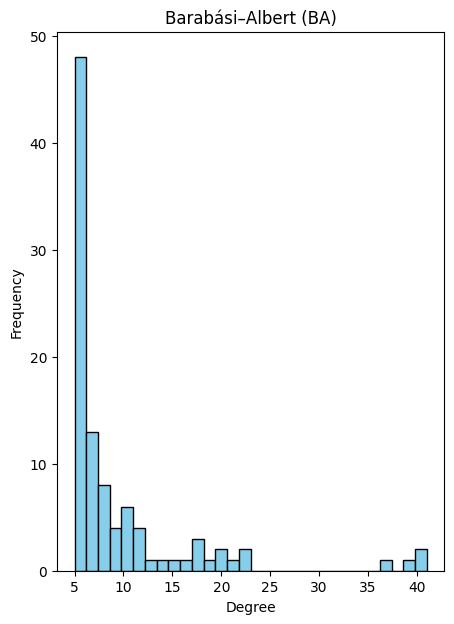

Average diameter:  2.16969696969697


In [5]:
import matplotlib.pyplot as plt

# plot the degree distribution of the networks
plt.figure(figsize=(5, 7))
plt.title("Barabási–Albert (BA)")
degrees_ba = [d for n, d in G.degree()]
plt.hist(degrees_ba, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# compute the average diameter of the network
avg_path_length = nx.average_shortest_path_length(G)
print("Average diameter: ", avg_path_length)

Both properties are satisfied. 

## Anonymization algorithm implementation    

In [6]:
# -1: e1 < e2
# 0: e1 = e2
# 1: e1 > e2
def compareEdges(e1, e2, dfs_time, dfs_edges):
    u1, v1 = sorted(e1)
    u2, v2 = sorted(e2)
    i1, j1 = dfs_time[u1], dfs_time[v1]
    i2, j2 = dfs_time[u2], dfs_time[v2]
    forward1 = dfs_edges[(u1, v1)]
    forward2 = dfs_edges[(u2, v2)]

    # Rule 1
    if forward1 and forward2:
        if j1 < j2: return -1
        elif j1 > j2: return 1
        elif i1 > i2: return -1
        elif i1 < i2: return 1
        else: return 0

    # Rule 2
    if not forward1 and not forward2:
        if i1 < i2: return -1
        elif i1 > i2: return 1
        elif j1 < j2: return -1
        elif j1 > j2: return 1
        else: return 0

    # Rule 3
    if forward1 and not forward2:
        return -1 if j1 <= i2 else 1

    # Rule 4
    if not forward1 and forward2:
        return -1 if i1 < j2 else 1
    
def make_compare_edges(dfs_time, mark_edges):
    # This returns a function that only takes e1, e2
    def compare(e1, e2):
        return compareEdges(e1, e2, dfs_time, mark_edges)
    return compare

In [359]:
'''
def dfs(G: nx.Graph):
    tick = [0]  # mutable counter, for proper update with many recursions 
    visited = set()
    dfs_time = {}
    dfs_edges = {}

    for u, v in G.edges():
         dfs_edges[tuple(sorted([u, v]))] = False # default: backward edges
    for node in sorted(G.nodes()):
        if node not in visited:
            dfs_visit(G, node, tick, dfs_time, visited, dfs_edges)
    
    return dfs_time, dfs_edges
'''

def dfs_visit(G: nx.Graph, node: int, tick: list, dfs_time: dict, visited: set, dfs_edges: dict):
    visited.add(node)
    tick[0] += 1
    dfs_time[node] = tick[0]
    for neighbor in sorted(G.neighbors(node)):
        if neighbor not in visited:
            dfs_edges[tuple(sorted([node, neighbor]))] = True
            dfs_visit(G, neighbor, tick, dfs_time, visited, dfs_edges)

from functools import cmp_to_key

def get_dfs_code_for_root(G, start_node):
    # Esegui la visita DFS partendo ESCLUSIVAMENTE da start_node
    # Nota: Assumiamo che G sia connesso (è un componente)
    tick = [0]
    visited = set()
    dfs_time = {}
    dfs_edges = {}
    
    # Inizializza edges come backward
    for u, v in G.edges():
         dfs_edges[tuple(sorted([u, v]))] = False 

    # Lancia la visita solo dalla root scelta
    dfs_visit(G, start_node, tick, dfs_time, visited, dfs_edges)
    
    # Genera il codice per questa specifica visita
    make_cmp = make_compare_edges(dfs_time, dfs_edges)
    EdgeList = [tuple(sorted(e)) for e in G.edges()]
    EdgeList_sorted = sorted(EdgeList, key=cmp_to_key(make_cmp))
    
    code = []
    for u, v in EdgeList_sorted:
        label_u = G.nodes[u]['label']
        label_v = G.nodes[v]['label']
        # Usiamo una tupla comparabile lessicograficamente
        code.append((dfs_time[u], dfs_time[v], label_u, label_v))
        
    # Gestione nodo singolo
    if not code and len(G.nodes()) == 1:
        u = next(iter(G.nodes()))
        label_u = G.nodes[u]['label']
        code.append((1, 1, label_u, None)) # Formato fittizio per comparazione
        
    return code

def minimumDFScode(G: nx.Graph):
    if not G.nodes():
        return []
    
    best_code = None
    
    for node in G.nodes():
        candidate_code = get_dfs_code_for_root(G, node)
        
        # Confronto lessicografico standard delle liste di tuple
        if best_code is None or candidate_code < best_code:
            best_code = candidate_code
            
    return best_code

In [8]:
def bfs_order(subgraph: nx.Graph, start: int) -> list:
    visited = set()
    queue = [start] 
    order = []

    while queue:
        node = queue.pop(0)
        if node not in visited:
            visited.add(node)
            order.append(node)
            for neighbor in sorted(subgraph.neighbors(node)): 
                if neighbor not in visited and neighbor not in queue:
                    queue.append(neighbor)

    return order

In [ ]:
# Nu1, Nv1: original neighborhood of u and v, respectively
# Nu2, Nv2: anonymized neighborhood of u and v, respectively

def anonymizazion_cost(Nu1: nx.Graph, Nv1: nx.Graph, Nu2: nx.Graph, Nv2: nx.Graph, label_domain: LabelDomain, alpha: float, beta: float, gamma: float) -> float:

    H1 = nx.compose(Nu1, Nv1)
    H2 = nx.compose(Nu2, Nv2)

    # first contribution
    ncp_cost = sum(label_domain.normalized_certainty_penalty(H2.nodes[n]['label']) for n in H2.nodes())
    ncp_cost *= alpha

    # second contribution
    added_edges = [(v1, v2) for v1, v2 in H2.edges() if not H1.has_edge(v1, v2)]
    edge_cost = beta * len(added_edges)

    # third contribution
    vertex_cost = gamma * (len(H2.nodes()) - len(H1.nodes()))

    return ncp_cost + edge_cost + vertex_cost

In [10]:
def choose_starting_matching_nodes(c_u: nx.Graph, c_v: nx.Graph, label_domain: LabelDomain) -> tuple[int, int]:  # deterministic & tested
    degree_label_candidate_pair = None
    max_degree = -1

    # Step 1: degree-label matches
    for x in sorted(c_u.nodes()): # sort for determinism
        label_x = c_u.nodes[x]['label']
        deg_x = c_u.degree[x]
        
        for y in sorted(c_v.nodes()): # sort for determinism
            label_y = c_v.nodes[y]['label']
            deg_y = c_v.degree[y]
            
            if deg_x == deg_y and label_x == label_y:
                if deg_x > max_degree or (deg_x == max_degree and (x, y) < degree_label_candidate_pair):  # last < for determinism
                    degree_label_candidate_pair = (x, y)
                    max_degree = deg_x

    if degree_label_candidate_pair:
        return degree_label_candidate_pair
    
    # Step 2: fallback - compute anonymization cost
    min_cost = float('inf')
    cost_candidate_pair = None

    for x in sorted(c_u.nodes()): # sort for determinism
        label_x = c_u.nodes[x]['label']
        deg_x = c_u.degree[x]

        for y in sorted(c_v.nodes()): # sort for determinism
            label_y = c_v.nodes[y]['label']
            deg_y = c_v.degree[y]

            general_label = label_domain.find_label_common_parent(label_x, label_y)
            cost = abs(deg_x - deg_y) + label_domain.normalized_certainty_penalty(general_label)
            # Update candidate pair if cost is smaller, or tie-break lexicographically
            if cost < min_cost or (cost == min_cost and (x, y) < cost_candidate_pair): # last < for determinism
                min_cost = cost
                cost_candidate_pair = (x, y)

    return cost_candidate_pair

In [11]:
def neighborhood_size_key(G, v):
    neighbors = list(G.neighbors(v))
    sub_nodes = [v] + neighbors
    subgraph = G.subgraph(sub_nodes)
    
    num_vertices = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()

    return (num_vertices, num_edges, v) # using v at the end make it deterministic

In [12]:
# Assume the following are true before calling the function:
# - node_map_1_2 and node_map_2_1 are:
#      - total (every node is mapped),
#      - bijective,
#      - inverses of each other.
# - comp1 and comp2 have the same number of nodes.
# - both are simple graphs (no multiedges, no direction).

def make_components_isomoprhic(comp1: nx.Graph, comp2: nx.Graph, node_map_1_2: dict, node_map_2_1: dict, label_domain: LabelDomain):
    
    comp1_anon, comp2_anon = comp1.copy(), comp2.copy()

    # Step 1: Generalize labels
    for n1, n2 in node_map_1_2.items():

        label1 = comp1_anon.nodes[n1]['label']
        label2 = comp2_anon.nodes[n2]['label']

        general_label = label_domain.find_label_common_parent(label1, label2)

        comp1_anon.nodes[n1]['label'] = general_label
        comp2_anon.nodes[n2]['label'] = general_label

    # shared nodes problem: (9, 22), (43, 9) -> 9 will get a label1 in comp1 and a label1 in comp2 and label1 might be different from label2
    shared_nodes = set(comp1_anon.nodes()).intersection(comp2_anon.nodes())
    for node in shared_nodes:
        label1 = comp1_anon.nodes[node]['label']
        label2 = comp2_anon.nodes[node]['label']
        
        general_label = label_domain.find_label_common_parent(label1, label2)
        
        comp1_anon.nodes[node]['label'] = general_label
        comp2_anon.nodes[node]['label'] = general_label

        #update the associated nodes
        comp1_anon.nodes[node_map_2_1[node]]['label'] = general_label
        comp2_anon.nodes[node_map_1_2[node]]['label'] = general_label

    # Step 2: Equalize neighborhoods
    for (w, z) in comp1_anon.edges():
        if not comp2_anon.has_edge(node_map_1_2[w], node_map_1_2[z]):
            comp2_anon.add_edge(node_map_1_2[w], node_map_1_2[z])

    for (w, z) in comp2_anon.edges():
        if not comp1_anon.has_edge(node_map_2_1[w], node_map_2_1[z]):
            comp1_anon.add_edge(node_map_2_1[w], node_map_2_1[z])

    return comp1_anon, comp2_anon

In [13]:
def find_missing_matching_vertex(G: nx.Graph, s: int, anonymized: dict, constraints: list, label_domain: LabelDomain)-> int:
    
    unanon_nodes = sorted(n for n, v in anonymized.items() if not v and n not in constraints) # deterministic

    if unanon_nodes:
        search_space = unanon_nodes
    else:
        search_space = sorted(n for n in G.nodes() if n not in constraints) # deterministic

    deg_dict = {n: G.degree(n) for n in search_space}
    min_deg = min(deg_dict.values())

    min_deg_nodes = sorted(n for n, d in deg_dict.items() if d == min_deg) # deterministic

    best_cost = float('inf')
    best_nodes = []

    for node in min_deg_nodes:
        general_label = label_domain.find_label_common_parent(G.nodes[node]['label'], G.nodes[s]['label'])
        cost = label_domain.normalized_certainty_penalty(general_label)

        if cost < best_cost:
            best_cost = cost
            best_nodes = [node]
        elif cost == best_cost:
            best_nodes.append(node)

    # deterministic tie-breaker
    return min(best_nodes)

In [14]:
# generalize the two centers labels
def generalize_labels(G: nx.Graph, u: int, v: int, label_domain: LabelDomain):
    label_u = G.nodes[u]['label']
    label_v = G.nodes[v]['label']
    general_label = label_domain.find_label_common_parent(label_u, label_v)
    G.nodes[u]['label'] = general_label 
    G.nodes[v]['label'] = general_label


In [313]:
# Remaining elements
# the new vertex cannot be equal to:
# - one in the neighborhood of the node in general -> they may have been already matched and i make change the components structure
# - the node itself
# - the previous external added nodes -> cannot count them twice
# - neither one of the current equality class -> equality class would break
# - the neighbors of the nodes in the equality class already anonymized (if label changes I'm dead, is it not isomoprhich anymore with the others)

def build_constraints(G: nx.Graph, center: int, eq_class: list[int], anonymized: dict, *extra_constraints: set[int]) -> set[int]: # tested & deterministic
    constraints = {center}
    #constraints = set()
    #for node in eq_class:
    #    if anonymized[node]:
    #        constraints.add(node)
    constraints.update(G.neighbors(center))
    for s in extra_constraints:
        constraints.update(s)

    return constraints

In [318]:
def build_component(G: nx.Graph, ref_comp: nx.Graph, ref_node: int, src_node: int, EquivalenceClassDict: dict, label_domain: LabelDomain) -> nx.Graph: # tested & deterministic

    node_map_1_2 = {}
    node_map_2_1 = {}
    anonymized = {n: data['anonymized'] for n, data in G.nodes(data=True)}

    for ref_node_in_comp in sorted(ref_comp.nodes()):
        print(f"Finding a match for node {ref_node_in_comp}")
        # as before + not in NeighborG(ref_node)
        #constraints = build_constraints(G, src_node, EquivalenceClassDict[src_node], anonymized, set(node_map_2_1.keys()), {ref_node}, set(G.neighbors(ref_node)))
        constraints = build_constraints(G, src_node, EquivalenceClassDict[src_node], anonymized, set(node_map_2_1.keys())) 
        print(f"Built constraints: {constraints}")
        new_vertex = find_missing_matching_vertex(G, ref_node_in_comp, anonymized, constraints, label_domain)

        if new_vertex is None:
            print("Empty vertex")
        else:
            print(f"New vertex found in build_component: {new_vertex} matching {ref_node_in_comp}")

        if anonymized[new_vertex]:
            for eq_node in EquivalenceClassDict[new_vertex]:
                anonymized[eq_node] = False

        node_map_1_2[ref_node_in_comp] = new_vertex
        node_map_2_1[new_vertex] = ref_node_in_comp

    src_comp = G.subgraph(node_map_2_1.keys())

    print("node_map_1_2: ", node_map_1_2)
    print("node_map_2_1: ", node_map_2_1)
    print("ref_comp node: ", list(ref_comp.nodes()))
    print("node_map_1_2: ", list(src_comp.nodes()))
    ref_comp_anon, src_comp_anon = make_components_isomoprhic(ref_comp, src_comp, node_map_1_2, node_map_2_1, label_domain)

    return ref_comp_anon, src_comp_anon

In [226]:
def match_and_generalize_components(G: nx.Graph, comp1: nx.Graph, comp2: nx.Graph, c1: int, c2: int, EquivalenceClassDict, label_domain: LabelDomain)-> tuple[nx.Graph, nx.Graph]: # tested & deterministic

    # we are simulating, i only modify anonymized label in the simulation
    anonymized = {n: data['anonymized'] for n, data in G.nodes(data=True)} # to not copy the entire graph

    (s1, s2) = choose_starting_matching_nodes(comp1, comp2, label_domain)
    
    order1, order2 = bfs_order(comp1, s1), bfs_order(comp2, s2)

    node_map_1_2 = {}
    node_map_2_1 = {}

    min_len = min(len(order1), len(order2))

    # Take pairs until one of the orders runs out
    for i in range(min_len):
        n1 = order1[i]
        n2 = order2[i]
        node_map_1_2[n1] = n2
        node_map_2_1[n2] = n1

    for n1 in order1[min_len:]:

        print(f"Finding a match for node {n1}")
        constraints = build_constraints(G, c2, EquivalenceClassDict[c2], anonymized, set(node_map_2_1.keys()))
        print("costraints: ", constraints)
        
        new_vertex = find_missing_matching_vertex(G, n1, anonymized, constraints, label_domain)
        print("new_vertex: ", new_vertex)

        # i need to expose it as unanonymized for next iterations
        if anonymized[new_vertex]:
            for node in EquivalenceClassDict[new_vertex]:
                anonymized[node] = False

        node_map_1_2[n1] = new_vertex
        node_map_2_1[new_vertex] = n1

    for n2 in order2[min_len:]:

        print(f"Finding a match for node {n2}")
        constraints = build_constraints(G, c1, EquivalenceClassDict[c1], anonymized, set(node_map_1_2.keys()))
        print("costraints: ", constraints)
        new_vertex = find_missing_matching_vertex(G, n2, anonymized, constraints, label_domain)
        print("new_vertex: ", new_vertex)

        # i need to expose it as unanonymized for next iterations
        if anonymized[new_vertex]:
            for node in EquivalenceClassDict[new_vertex]:
                anonymized[node] = False

        node_map_1_2[new_vertex] = n2
        node_map_2_1[n2] = new_vertex

    # end of mapping -> create the anon copies
    comp1, comp2 = G.subgraph(node_map_1_2.keys()), G.subgraph(node_map_2_1.keys())
    comp1_anon, comp2_anon = make_components_isomoprhic(comp1, comp2, node_map_1_2, node_map_2_1, label_domain)

    return comp1_anon, comp2_anon

In [223]:
def most_similar_component(G, ref_comp_id: int, component_graphs: dict, unmatched_component_ids: set[int], ref_node,
    src_node, EquivalenceClassDict, label_domain, alpha, beta, gamma) -> tuple[int, nx.Graph, nx.Graph]:

    best_cost = float('inf')
    most_similar_id = float('inf')
    best_ref_anon = None
    best_unm_anon = None
    
    # Deterministic ordering of IDs
    sorted_unmatched_ids = sorted(unmatched_component_ids)
    
    # The reference component subgraph
    ref_comp = component_graphs[ref_node][ref_comp_id]

    for unm_id in sorted_unmatched_ids:
        unm_comp = component_graphs[src_node][unm_id]

        # Work on copies inside match_and_generalize_components
        ref_anon, unm_anon = match_and_generalize_components(G, ref_comp, unm_comp, ref_node, src_node, EquivalenceClassDict, label_domain)

        cost = anonymizazion_cost(ref_comp, unm_comp, ref_anon, unm_anon, label_domain, alpha, beta, gamma)

        # Deterministic tie-breaker
        if cost < best_cost or (cost == best_cost and unm_id < most_similar_id):
            best_cost = cost
            best_ref_anon = ref_anon
            best_unm_anon = unm_anon
            most_similar_id = unm_id

    return most_similar_id, best_ref_anon, best_unm_anon

In [19]:
def get_neighborhood_components(G: nx.Graph, u: int, v: int): # deterministic

    # Neighborhood subgraphs
    Nu = G.subgraph(sorted(G.neighbors(u))).copy()
    Nv = G.subgraph(sorted(G.neighbors(v))).copy()

    # Connected components of the neighborhoods
    Cu = [sorted(c) for c in nx.connected_components(Nu)]
    Cv = [sorted(c) for c in nx.connected_components(Nv)]

    # Sort components by smallest node ID (deterministic ordering)
    Cu.sort(key=lambda nodes: nodes[0] if nodes else float('inf'))
    Cv.sort(key=lambda nodes: nodes[0] if nodes else float('inf'))

    print(f"Number of components node {u}: {len(Cu)}")
    print(f"Number of components node {v}: {len(Cv)}")

    # Build component subgraphs with deterministic IDs
    component_graphs = {
        u: {i: Nu.subgraph(nodes).copy() for i, nodes in enumerate(Cu)},
        v: {i: Nv.subgraph(nodes).copy() for i, nodes in enumerate(Cv)}
    }

    unmatched_components = {
        u: set(component_graphs[u].keys()),
        v: set(component_graphs[v].keys())
    }

    return component_graphs, unmatched_components

In [20]:
def update_graph(G: nx.Graph, c_u_anon: nx.Graph, c_v_anon: nx.Graph, u: int, v: int): # deterministic & tested

    G.add_nodes_from(c_u_anon.nodes(data=True))  # include attributes
    G.add_edges_from(c_u_anon.edges(data=True))  # include attributes
    for node in c_u_anon:
        G.add_edge(u, node) # if i added a vertex to a component, this link is missing

    G.add_nodes_from(c_v_anon.nodes(data=True))  # include attributes
    G.add_edges_from(c_v_anon.edges(data=True))  # include attributes
    for node in c_v_anon:
        G.add_edge(v, node)

In [329]:
def find_perfect_comp_matches(u, v, component_graphs, unmatched_components): # deterministic

    for cu_id in sorted(unmatched_components[u]): 
        c_u = component_graphs[u][cu_id]
        matched_cv_id = None
        for cv_id in sorted(unmatched_components[v]):
            c_v = component_graphs[v][cv_id]
            if minimumDFScode(c_u) == minimumDFScode(c_v):
                matched_cv_id = cv_id
                print("1 perfect component match!")
                print(f"Matched: {list(c_u.nodes)} - {list(c_v.nodes)}")
                break
        if matched_cv_id is not None:
            unmatched_components[u].remove(cu_id)
            unmatched_components[v].remove(matched_cv_id)
    
    return unmatched_components

In [22]:
import matplotlib.pyplot as plt

def plot_colored_graph(G, special_nodes, special_color='green', default_color='lightblue'):
    # Start with all nodes as default color
    node_colors = {node: default_color for node in G.nodes()}
    
    # Highlight special nodes and their neighbors
    for node in special_nodes:
        node_colors[node] = special_color
        for neighbor in G.neighbors(node):
            node_colors[neighbor] = special_color
    
    # Get the list of colors in the order of G.nodes()
    colors = [node_colors[node] for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G)  # nice layout
    nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=800)
    plt.show()

def plot_component(comp, title="Component"):
    pos = nx.spring_layout(comp, seed=42)  # deterministic layout
    plt.figure(figsize=(6, 6))
    
    # Draw nodes
    nx.draw_networkx_nodes(comp, pos, node_color='skyblue', node_size=600, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(comp, pos, width=1.5, alpha=0.7)
    
    # Draw labels: show node id and node label
    node_labels = {n: f"{n}\n{comp.nodes[n]['label']}" for n in comp.nodes()}
    nx.draw_networkx_labels(comp, pos, labels=node_labels, font_size=10, font_color='black')
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


In [335]:
def anonymized_nodes_with_changes(G_before: nx.Graph, G_after: nx.Graph):
    changed_nodes = set()

    # old nodes modified
    for node in G_before.nodes():
        if G_before.nodes[node]['anonymized']:
            # Check label change
            label_before = G_before.nodes[node]['label']
            label_after  = G_after.nodes[node]['label']
            label_changed = (label_before != label_after)

            # Check neighbors change
            neighbors_before = set(G_before.neighbors(node))
            neighbors_after  = set(G_after.neighbors(node))
            neighbors_changed = (neighbors_before != neighbors_after)

            if label_changed or neighbors_changed:
                changed_nodes.add(node)

    # new nodes
    for node in set(G_after.nodes()) - set(G_before.nodes()):
        if G_after.nodes[node]['anonymized']:
            changed_nodes.add(node)

    return changed_nodes

In [297]:
def process_modified_anonymized_nodes(
    G: nx.Graph,
    added_anon_nodes: list,
    EquivalenceClassDict: dict,
    VertexList: list,
    neighborhood_size_key):
    processed_classes = []

    for added_anon in added_anon_nodes:
        # Skip nodes that are already in a processed equivalence class
        skip = False
        for processed_class in processed_classes:
            if added_anon in processed_class:
                skip = True
                break
        if skip:
            continue

        # Get the equivalence class for this node
        eq_class_nodes = EquivalenceClassDict[added_anon]

        # Track this class to avoid duplicate processing
        processed_classes.append(eq_class_nodes)

        # Reset 'anonymized' flags for the class
        for n in eq_class_nodes:
            G.nodes[n]['anonymized'] = False

        # Extend and sort the VertexList
        VertexList.extend(eq_class_nodes)
        VertexList.sort(key=lambda v: neighborhood_size_key(G, v))

        # Remove processed nodes from EquivalenceClassDict
        for n in eq_class_nodes:
            if n in EquivalenceClassDict:
                del EquivalenceClassDict[n]


In [330]:
def anonymize_pair(G: nx.Graph, u: int, v: int, label_domain: LabelDomain, VertexList: list, EquivalenceClassDict: dict, alpha: float, beta: float, gamma: float) -> tuple[nx.Graph, nx.Graph]:

    # Get neighborhood components
    component_graphs, unmatched_components = get_neighborhood_components(G, u, v) # deterministic

    # find perfect matches
    unmatched_components = find_perfect_comp_matches(u, v, component_graphs, unmatched_components) # deterministic
    
    while unmatched_components[u] and unmatched_components[v]:
        print("unmatched_components: ", unmatched_components)
        # choose the largest component
        largest_u_id = max(unmatched_components[u],
            key=lambda cid: (
                component_graphs[u][cid].number_of_nodes(),
                -min(component_graphs[u][cid].nodes())))
        
        largest_v_id = max(unmatched_components[v],
            key=lambda cid: (
                component_graphs[v][cid].number_of_nodes(),
                -min(component_graphs[v][cid].nodes())))
        
        largest_u_component = component_graphs[u][largest_u_id]
        largest_v_component = component_graphs[v][largest_v_id]
        
        if largest_u_component.number_of_nodes() >= largest_v_component.number_of_nodes():
            target, source = u, v
            largest_id, largest = largest_u_id, largest_u_component
        else:
            target, source = v, u
            largest_id, largest = largest_v_id, largest_v_component

        most_similar_id, target_anon, source_anon = most_similar_component(
                G,
                largest_id,
                component_graphs=component_graphs,
                unmatched_component_ids=unmatched_components[source],
                ref_node=target,
                src_node=source,
                EquivalenceClassDict=EquivalenceClassDict,
                label_domain=label_domain,
                alpha=alpha,
                beta=beta,
                gamma=gamma
            )
        
        modified_src_anon_nodes = anonymized_nodes_with_changes(component_graphs[source][most_similar_id], source_anon)
        modified_trg_anon_nodes = anonymized_nodes_with_changes(largest, target_anon)
        modified_anon_nodes = modified_trg_anon_nodes | modified_src_anon_nodes

        update_graph(G, target_anon, source_anon, target, source)

        # qui perchè altrimenti anonymize false viene perso da update graph
        process_modified_anonymized_nodes(G, modified_anon_nodes, EquivalenceClassDict, VertexList, neighborhood_size_key)
        VertexList.sort(key=lambda v: neighborhood_size_key(G, v), reverse=True) # degree may be changed

        unmatched_components[target].remove(largest_id)
        unmatched_components[source].remove(most_similar_id)
        print("1 partial component match!")
        print(f"Matched: {list(target_anon.nodes)} - {list(source_anon.nodes)}")

    # orphaned components
    if unmatched_components[u] and not unmatched_components[v]:
    # Cv is empty, Cu has extra components
        target = u
        source = v
        extras = unmatched_components[u].copy()
    elif not unmatched_components[u] and unmatched_components[v]:
    # Cu is empty, Cv has extra components
        target = v
        source = u
        extras = unmatched_components[v].copy()
    else:
        extras = []

    for cid in extras:
        extra = component_graphs[target][cid]
        print("Component without match: ", list(extra.nodes()))
        target_anon, source_anon = build_component(G, extra, target, source, EquivalenceClassDict, label_domain) # anon must be copies
        original_built_component = G.subgraph(list(source_anon.nodes())).copy()
        
        modified_src_anon_nodes = anonymized_nodes_with_changes(original_built_component, source_anon)
        modified_trg_anon_nodes = anonymized_nodes_with_changes(extra, target_anon)
        modified_anon_nodes = modified_trg_anon_nodes | modified_src_anon_nodes

        ## NEED TO MODIFY THE GRAPH -> in place
        update_graph(G, target_anon, source_anon, target, source)

        # qui perchè altrimenti anonymize false viene perso da update graph
        process_modified_anonymized_nodes(G, modified_anon_nodes, EquivalenceClassDict, VertexList, neighborhood_size_key)
        VertexList.sort(key=lambda v: neighborhood_size_key(G, v), reverse=True) # degree may be changed
        
        unmatched_components[target].remove(cid)
        print("1 ad hoc component match!")
        print(f"Matched: {list(target_anon.nodes)} - {list(source_anon.nodes)}")

    # generalize the two centers labels
    generalize_labels(G, u, v, label_domain)

In [383]:
def anonymize_graph(G: nx.Graph, k: int, label_domain: LabelDomain, alpha: float, beta: float, gamma: float)-> nx.Graph:
    
    G_anon = G.copy()
    VertexList = sorted(G_anon.nodes, key=lambda v: neighborhood_size_key(G_anon, v), reverse=True)  # descending order

    EquivalenceClassDict = {}
    nx.set_node_attributes(G_anon, False, 'anonymized')

    while VertexList:
        print("------------------------------")
        print("VertexList: ", VertexList)
        SeedVertex = VertexList.pop(0) # remove and return
        label_seed = G_anon.nodes[SeedVertex]['label']
        deg_seed = G_anon.degree[SeedVertex]

        costs = {}
        for v in VertexList:
            # order by cost based on degree difference + NPC
            label_v = G_anon.nodes[v]['label']
            deg_v = G_anon.degree[v]

            general_label = label_domain.find_label_common_parent(label_seed, label_v)
            costs[v] = abs(deg_seed - deg_v) + label_domain.normalized_certainty_penalty(general_label)

        # select candidate set
        if len(VertexList) >= (2*k - 1):
            sorted_cost = sorted(costs.items(), key=lambda item: item[1])
            candidate_set = [node for node, _ in sorted_cost[:k-1]]

        else: 
            candidate_set = VertexList.copy() # otherwise if i remove a node from VertexList is remove also from candidate_set

        for v in [SeedVertex] + candidate_set:
            EquivalenceClassDict[v] = [SeedVertex] + candidate_set

        print("K: ", k)
        print("candidate_set: ", candidate_set)
        print("SeedVertex: ", SeedVertex)
        u1 = candidate_set[0]
        print(f"Processing: {SeedVertex} - {u1}")
        anonymize_pair(G_anon, SeedVertex, u1, label_domain, VertexList, EquivalenceClassDict, alpha, beta, gamma)
        # i need tu update G_anon -> incrementally anonymize in place.
        #G_anon.nodes[SeedVertex]['anonymized'] = True
        #G_anon.nodes[u1]['anonymized'] = True
        
        VertexList.remove(u1)
        print(f"Remove {u1} from VertexList")

        # i need to incrementally improve G_anon
        for j in range(2, len(candidate_set)+1): #otherwise skips the last element
            uj = candidate_set[j-1]
            
            for v in [SeedVertex] + candidate_set[:j-1]:
                print(f"Processing: {uj} - {v} candidate_set: {candidate_set}")
                anonymize_pair(G_anon, uj, v, label_domain, VertexList, EquivalenceClassDict, alpha, beta, gamma)
            #G_anon.nodes[uj]['anonymized'] = True
            
            VertexList.remove(uj)
            print(f"Remove {uj} from VertexList")

        print("End of eq class: ", [SeedVertex] + candidate_set)
        print("candidate_set: ", candidate_set)
        for node in [SeedVertex] + candidate_set:
            G_anon.nodes[node]['anonymized'] = True
            
            if node in VertexList:
                VertexList.remove(node)

        # Re-sort list because neighborhood sizes might have changed
        VertexList.sort(key=lambda v: neighborhood_size_key(G_anon, v), reverse=True)

    return G_anon

In [148]:
import networkx as nx
from networkx.algorithms import isomorphism

def check_isomorphic_classes(G: nx.Graph, EquivalenceClassDict):
    """
    Given a graph G and a dictionary mapping node -> equivalence class nodes,
    return a mapping of class_id -> list of lists of truly isomorphic nodes.
    """

    processed_classes = set()  # track already-processed equivalence classes
    iso_class_result = []      # list of lists of nodes that are isomorphic

    for node, eq_class_nodes in EquivalenceClassDict.items():
        # Skip if already processed (same list)
        class_id = tuple(sorted(eq_class_nodes))  # canonical representation
        if class_id in processed_classes:
            continue
        processed_classes.add(class_id)

        # Start with first node as reference
        subgraphs_by_iso = []  # each element is a list of nodes isomorphic to each other
        reference_node = eq_class_nodes[0]
        reference_subgraph = G.subgraph([reference_node] + list(G.neighbors(reference_node))).copy()
        current_iso_group = [reference_node]

        for n in eq_class_nodes[1:]:
            subG = G.subgraph([n] + list(G.neighbors(n))).copy()

            # Use GraphMatcher to check isomorphism
            GM = isomorphism.GraphMatcher(reference_subgraph, subG,
                                          node_match=isomorphism.categorical_node_match('label', None),
                                          edge_match=isomorphism.categorical_edge_match('label', None))
            if GM.is_isomorphic():
                current_iso_group.append(n)
            else:
                # start a new iso group with this node as reference
                subgraphs_by_iso.append(current_iso_group)
                reference_subgraph = subG
                current_iso_group = [n]

        # append last group
        subgraphs_by_iso.append(current_iso_group)

        iso_class_result.extend(subgraphs_by_iso)

    return iso_class_result

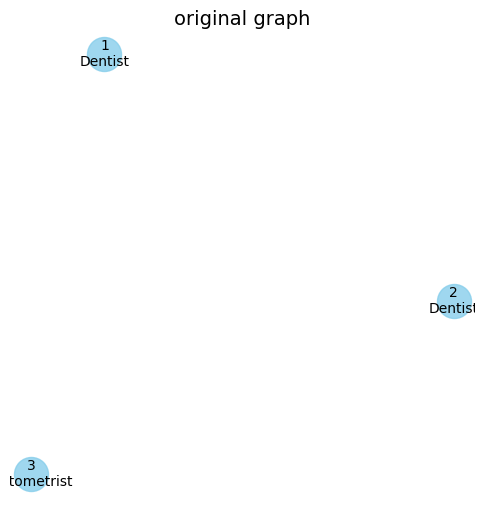

------------------------------
VertexList:  [3, 2, 1]
K:  3
candidate_set:  [2, 1]
SeedVertex:  3
Processing: 3 - 2
Number of components node 3: 0
Number of components node 2: 0
Remove 2 from VertexList
Processing: 1 - 3 candidate_set: [2, 1]
Number of components node 1: 0
Number of components node 3: 0
Processing: 1 - 2 candidate_set: [2, 1]
Number of components node 1: 0
Number of components node 2: 0
Remove 1 from VertexList
End of eq class:  [3, 2, 1]
candidate_set:  [2, 1]


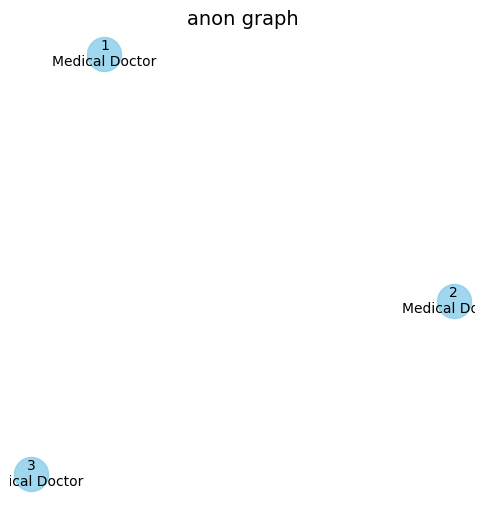

In [379]:
disconneted_G = nx.Graph()
disconneted_G.add_nodes_from([1, 2, 3])
disconneted_G = assign_randomly_leaf_labels(disconneted_G, label_domain, seed = 42)
plot_component(disconneted_G, "original graph")
G_anon = anonymize_graph(disconneted_G, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

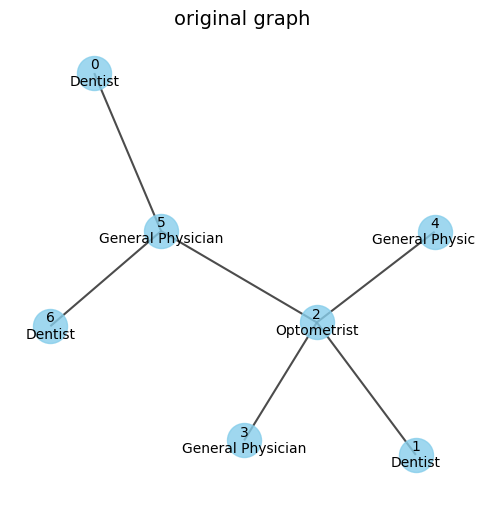

------------------------------
VertexList:  [2, 5, 6, 4, 3, 1, 0]
K:  2
candidate_set:  [5]
SeedVertex:  2
Processing: 2 - 5
Number of components node 2: 4
Number of components node 5: 3
1 perfect component match!
Matched: [1] - [0]
unmatched_components:  {2: {1, 2, 3}, 5: {1, 2}}
1 partial component match!
Matched: [3] - [2]
unmatched_components:  {2: {2, 3}, 5: {2}}
1 partial component match!
Matched: [4] - [6]
Component without match:  [5]
Finding a match for node 5
Built constraints: {0, 2, 5, 6}
New vertex found in build_component: 1 matching 5
node_map_1_2:  {5: 1}
node_map_2_1:  {1: 5}
ref_comp node:  [5]
node_map_1_2:  [1]
1 ad hoc component match!
Matched: [5] - [1]
Remove 5 from VertexList
End of eq class:  [2, 5]
candidate_set:  [5]
------------------------------
VertexList:  [1, 6, 4, 3, 0]
K:  2
candidate_set:  [6]
SeedVertex:  1
Processing: 1 - 6
Number of components node 1: 1
Number of components node 6: 1
unmatched_components:  {1: {0}, 6: {0}}
Finding a match for node 

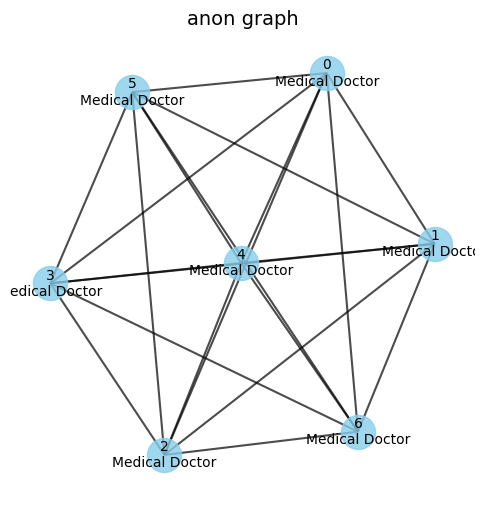

In [388]:
two_stars_G = nx.Graph()
two_stars_G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
two_stars_G.add_edges_from([(1, 2), (3, 2), (4, 2), (2, 5), (5, 6), (5, 0)]) 

two_stars_G = assign_randomly_leaf_labels(two_stars_G, label_domain, seed = 42)
plot_component(two_stars_G, "original graph")
G_anon = anonymize_graph(two_stars_G, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")
#iso_classes = check_isomorphic_classes(G_anon, equivalence_dict)
#print("Isomorphic subgraph groups:")
#for group in iso_classes:
#    print(group)

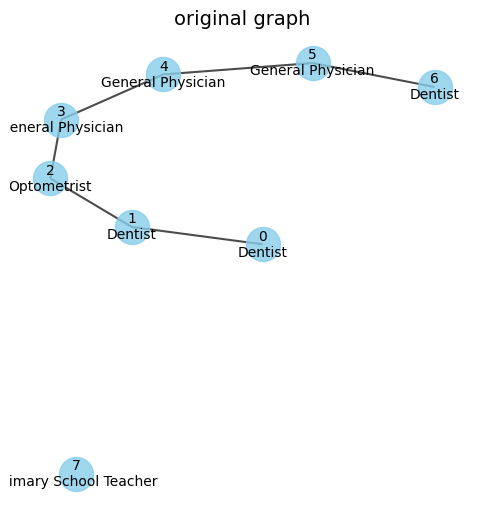

------------------------------
VertexList:  [5, 4, 3, 2, 1, 6, 0, 7]
K:  2
candidate_set:  [4]
SeedVertex:  5
Processing: 5 - 4
Number of components node 5: 2
Number of components node 4: 2
1 perfect component match!
Matched: [4] - [3]
unmatched_components:  {5: {1}, 4: {1}}
1 partial component match!
Matched: [6] - [5]
Remove 4 from VertexList
End of eq class:  [5, 4]
candidate_set:  [4]
------------------------------
VertexList:  [3, 2, 1, 6, 0, 7]
K:  2
candidate_set:  [2]
SeedVertex:  3
Processing: 3 - 2
Number of components node 3: 2
Number of components node 2: 2
unmatched_components:  {3: {0, 1}, 2: {0, 1}}
1 partial component match!
Matched: [2] - [1]
unmatched_components:  {3: {1}, 2: {1}}
1 partial component match!
Matched: [4] - [3]
Remove 2 from VertexList
End of eq class:  [3, 2]
candidate_set:  [2]
------------------------------
VertexList:  [1, 6, 0, 7]
K:  2
candidate_set:  [6]
SeedVertex:  1
Processing: 1 - 6
Number of components node 1: 2
Number of components node 6: 

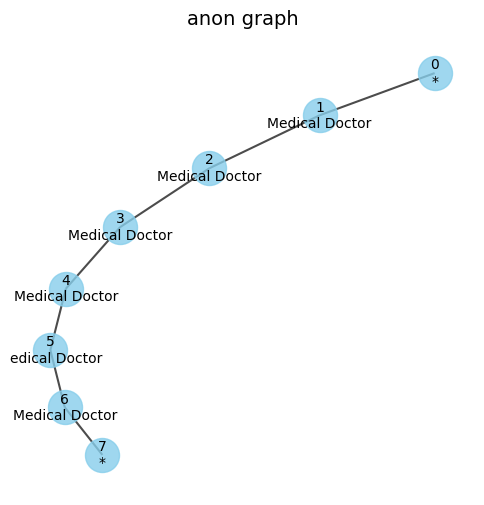

In [386]:
pentagon_G = nx.Graph()
pentagon_G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7])
pentagon_G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]) 

pentagon_G = assign_randomly_leaf_labels(pentagon_G, label_domain, seed = 42)
plot_component(pentagon_G, "original graph")
G_anon = anonymize_graph(pentagon_G, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")
#iso_classes = check_isomorphic_classes(G_anon, equivalence_dict)
#print("Isomorphic subgraph groups:")
#for group in iso_classes:
#    print(group)

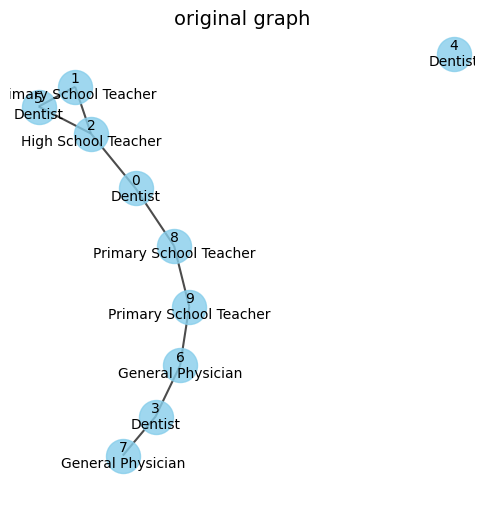

------------------------------
VertexList:  [2, 5, 1, 9, 8, 6, 3, 0, 7, 4]
K:  2
candidate_set:  [1]
SeedVertex:  2
Processing: 2 - 1
Number of components node 2: 2
Number of components node 1: 1
unmatched_components:  {2: {0, 1}, 1: {0}}
1 partial component match!
Matched: [1, 5] - [2, 5]
Component without match:  [0]
Finding a match for node 0
Built constraints: {1, 2, 5}
New vertex found in build_component: 4 matching 0
node_map_1_2:  {0: 4}
node_map_2_1:  {4: 0}
ref_comp node:  [0]
node_map_1_2:  [4]
1 ad hoc component match!
Matched: [0] - [4]
Remove 1 from VertexList
End of eq class:  [2, 1]
candidate_set:  [1]
------------------------------
VertexList:  [5, 9, 8, 6, 3, 0, 7, 4]
K:  2
candidate_set:  [3]
SeedVertex:  5
Processing: 5 - 3
Number of components node 5: 1
Number of components node 3: 2
unmatched_components:  {5: {0}, 3: {0, 1}}
Finding a match for node 2
costraints:  {3, 6, 7}
new_vertex:  4
Finding a match for node 2
costraints:  {3, 6, 7}
new_vertex:  4
1 partial co

KeyError: 5

In [385]:
G_random = nx.gnp_random_graph(n=10, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [321]:
nx.density(G_anon)

0.26666666666666666

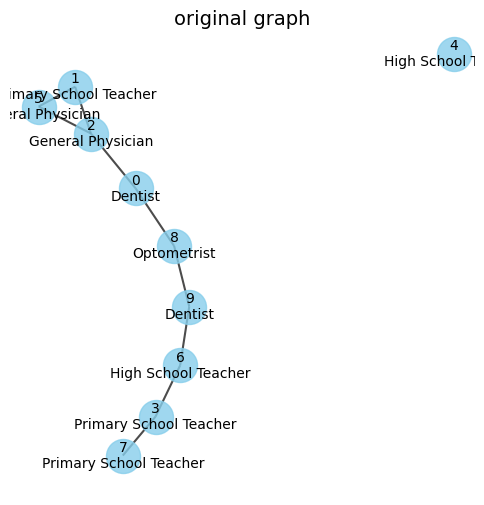

------------------------------
VertexList:  [2, 5, 1, 9, 8, 6, 3, 0, 7, 4]
K:  3
candidate_set:  [5, 9]
SeedVertex:  2
Processing: 2 - 5
Number of components node 2: 2
Number of components node 5: 1
1 perfect component match!
Matched: [1, 5] - [1, 2]
Component without match:  [0]
Finding a match for node 0
Built constraints: {1, 2, 5}
New vertex found in build_component: 4 matching 0
node_map_1_2:  {0: 4}
node_map_2_1:  {4: 0}
ref_comp node:  [0]
node_map_1_2:  [4]
1 ad hoc component match!
Matched: [0] - [4]
Remove 5 from VertexList
Processing: 9 - 2 candidate_set: [5, 9]
Number of components node 9: 2
Number of components node 2: 2
unmatched_components:  {9: {0, 1}, 2: {0, 1}}
Finding a match for node 5
costraints:  {8, 9, 6}
new_vertex:  4
Finding a match for node 1
costraints:  {8, 9, 6}
new_vertex:  7
1 partial component match!
Matched: [1, 5] - [8, 7]
unmatched_components:  {9: {0}, 2: {0}}
1 partial component match!
Matched: [6] - [0]
Processing: 9 - 5 candidate_set: [5, 9]
Numb

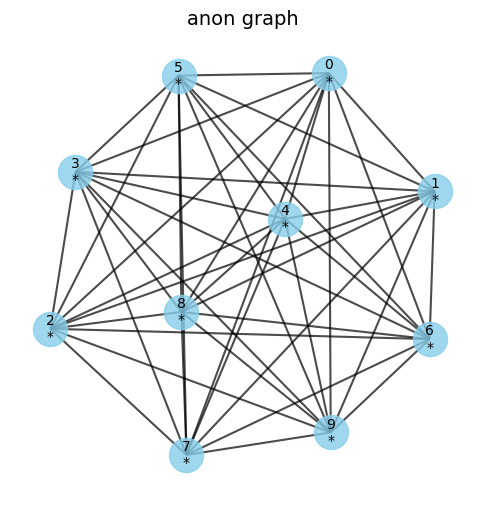

In [364]:
G_random = nx.gnp_random_graph(n=10, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

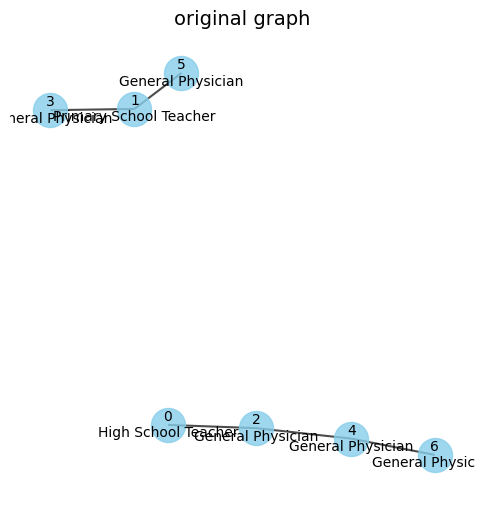

------------------------------
VertexList:  [4, 2, 1, 6, 5, 3, 0]
K:  2
candidate_set:  [2]
SeedVertex:  4
Processing: 4 - 2
Number of components node 4: 2
Number of components node 2: 2
1 perfect component match!
Matched: [2] - [4]
unmatched_components:  {4: {1}, 2: {0}}
1 partial component match!
Matched: [6] - [0]
Remove 2 from VertexList
End of eq class:  [4, 2]
candidate_set:  [2]
------------------------------
VertexList:  [1, 6, 5, 3, 0]
K:  2
candidate_set:  [6]
SeedVertex:  1
Processing: 1 - 6
Number of components node 1: 2
Number of components node 6: 1
1 perfect component match!
Matched: [3] - [4]
Component without match:  [5]
Finding a match for node 5
Built constraints: {4, 6}
New vertex found in build_component: 3 matching 5
node_map_1_2:  {5: 3}
node_map_2_1:  {3: 5}
ref_comp node:  [5]
node_map_1_2:  [3]
1 ad hoc component match!
Matched: [5] - [3]
Remove 6 from VertexList
End of eq class:  [1, 6]
candidate_set:  [6]
------------------------------
VertexList:  [3, 5, 0]

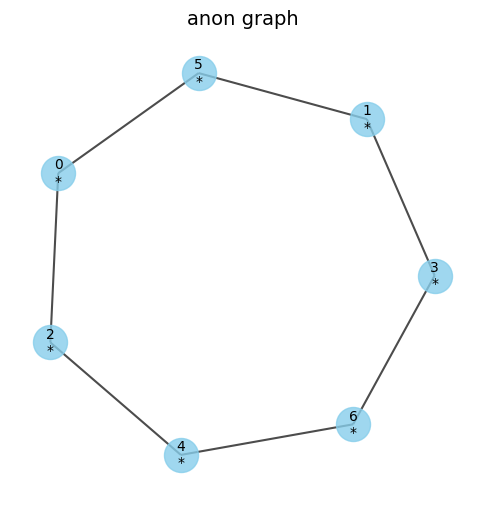

In [376]:
G_random = nx.gnp_random_graph(n=7, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain, seed=24)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [352]:
nx.density(G_anon)

0.3333333333333333

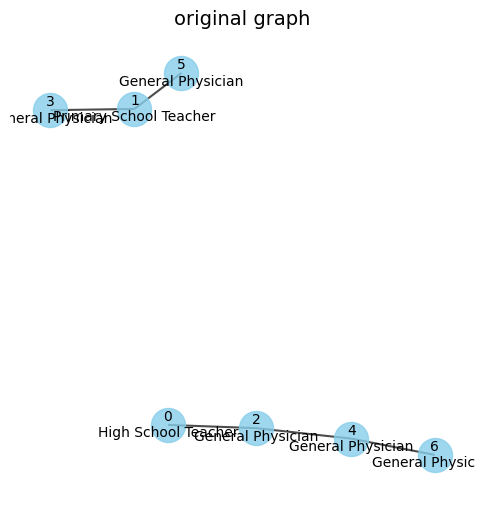

------------------------------
VertexList:  [4, 2, 1, 6, 5, 3, 0]
K:  3
candidate_set:  [2, 1]
SeedVertex:  4
Processing: 4 - 2
Number of components node 4: 2
Number of components node 2: 2
1 perfect component match!
Matched: [2] - [4]
unmatched_components:  {4: {1}, 2: {0}}
1 partial component match!
Matched: [6] - [0]
Remove 2 from VertexList
Processing: 1 - 4 candidate_set: [2, 1]
Number of components node 1: 2
Number of components node 4: 2
1 perfect component match!
Matched: [3] - [2]
unmatched_components:  {1: {1}, 4: {1}}
1 partial component match!
Matched: [5] - [6]
Processing: 1 - 2 candidate_set: [2, 1]
Number of components node 1: 2
Number of components node 2: 2
1 perfect component match!
Matched: [5] - [0]
unmatched_components:  {1: {0}, 2: {1}}
1 partial component match!
Matched: [3] - [4]
Remove 1 from VertexList
End of eq class:  [4, 2, 1]
candidate_set:  [2, 1]
------------------------------
VertexList:  [6, 5, 3, 0]
K:  3
candidate_set:  [5, 3, 0]
SeedVertex:  6
Proce

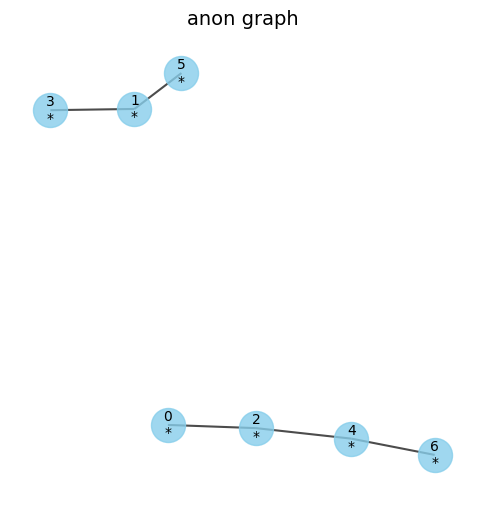

In [366]:
G_random = nx.gnp_random_graph(n=7, p=0.1, seed=42)
G_random = assign_randomly_leaf_labels(G_random, label_domain, seed=24)
plot_component(G_random, "original graph")
G_anon = anonymize_graph(G_random, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

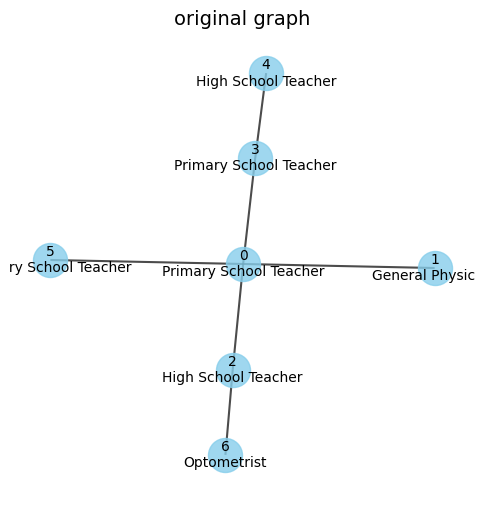

------------------------------
VertexList:  [0, 3, 2, 6, 5, 4, 1]
K:  2
candidate_set:  [3]
SeedVertex:  0
Processing: 0 - 3
Number of components node 0: 4
Number of components node 3: 2
1 perfect component match!
Matched: [2] - [4]
1 perfect component match!
Matched: [3] - [0]
Component without match:  [1]
Finding a match for node 1
Built constraints: {0, 3, 4}
New vertex found in build_component: 1 matching 1
node_map_1_2:  {1: 1}
node_map_2_1:  {1: 1}
ref_comp node:  [1]
node_map_1_2:  [1]
1 ad hoc component match!
Matched: [1] - [1]
Component without match:  [5]
Finding a match for node 5
Built constraints: {0, 1, 3, 4}
New vertex found in build_component: 5 matching 5
node_map_1_2:  {5: 5}
node_map_2_1:  {5: 5}
ref_comp node:  [5]
node_map_1_2:  [5]
1 ad hoc component match!
Matched: [5] - [5]
Remove 3 from VertexList
End of eq class:  [0, 3]
candidate_set:  [3]
------------------------------
VertexList:  [5, 1, 2, 6, 4]
K:  2
candidate_set:  [2]
SeedVertex:  5
Processing: 5 - 2
N

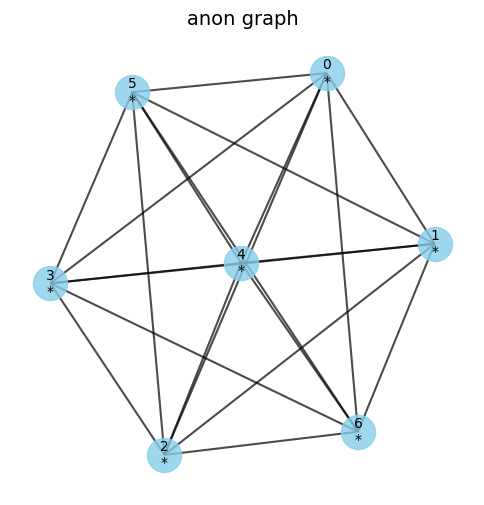

In [374]:
n= 7
m = 1
G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=42)
G_ba = assign_randomly_leaf_labels(G_ba, label_domain, seed=53)
plot_component(G_ba, "original graph")
G_anon = anonymize_graph(G_ba, 2, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")

In [375]:
nx.density(G_anon)

1.0

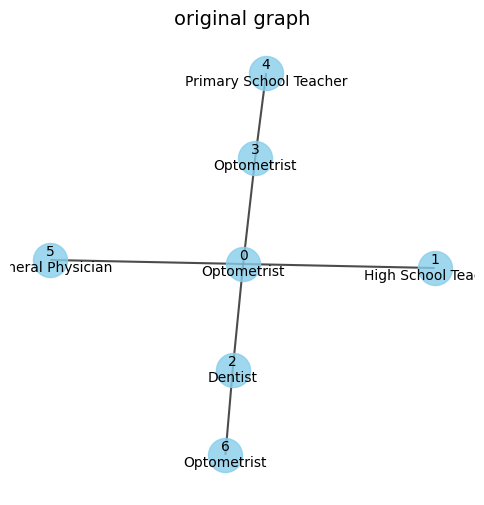

------------------------------
VertexList:  [0, 3, 2, 6, 5, 4, 1]
K:  3
candidate_set:  [3, 2]
SeedVertex:  0
Processing: 0 - 3
Number of components node 0: 4
Number of components node 3: 2
1 perfect component match!
Matched: [3] - [0]
unmatched_components:  {0: {0, 1, 3}, 3: {1}}
1 partial component match!
Matched: [1] - [4]
Component without match:  [2]
Finding a match for node 2
Built constraints: {0, 3, 4}
New vertex found in build_component: 5 matching 2
node_map_1_2:  {2: 5}
node_map_2_1:  {5: 2}
ref_comp node:  [2]
node_map_1_2:  [5]
1 ad hoc component match!
Matched: [2] - [5]
Component without match:  [5]
Finding a match for node 5
Built constraints: {0, 3, 4, 5}
New vertex found in build_component: 6 matching 5
node_map_1_2:  {5: 6}
node_map_2_1:  {6: 5}
ref_comp node:  [5]
node_map_1_2:  [6]
1 ad hoc component match!
Matched: [5] - [6]
Remove 3 from VertexList
Processing: 2 - 0 candidate_set: [3, 2]
Number of components node 2: 2
Number of components node 0: 3
1 perfect comp

KeyError: 2

In [357]:
n= 7
m = 1
G_ba = nx.barabasi_albert_graph(n=n, m=m, seed=42)
G_ba = assign_randomly_leaf_labels(G_ba, label_domain)
plot_component(G_ba, "original graph")
G_anon = anonymize_graph(G_ba, 3, label_domain, 1, 1, 1)
plot_component(G_anon, "anon graph")